In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip3 install pyro-ppl

In [1]:
# Load necessary libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import os
from collections import defaultdict

import torch
import torch.nn as nn

from tqdm import tqdm
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, EmpiricalMarginal
from pyro.optim import Adam, SGD
import torch.distributions.constraints as constraints

import pyro.distributions as dist
import pyro.distributions.transforms as T

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#to utilize GPU capabilities
USE_CUDA = True

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

from pyro.nn import pyro_method

In [2]:
from pyro.distributions import (
    Bernoulli, Beta, Gamma, Independent, MultivariateNormal,
    Normal, TorchDistribution, LowRankMultivariateNormal
)

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm

In [4]:
# datapath = '/content/drive/MyDrive/Colab Notebooks/CausalVAE/datasets/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
datapath = '/home/sayem/Desktop/Code/datasets/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
dataset_zip = np.load(datapath,
                      encoding = 'bytes', 
                      allow_pickle=True
                      )
                      
# for i, name in enumerate(dataset_zip.keys()):
#     print(name, type(name))


In [5]:
class Encoder(nn.Module):
	"""
    MLPs (multi-layered perceptrons or simple feed-forward networks)l
    where the provided activation parameter is used on every linear layer except
    for the output layer where we use the provided output_activation parameter
	"""
	def __init__(self, image_dim, label_dim, z_dim):
		super(Encoder, self).__init__()
		#setup image and label dimensions from the dataset
		self.image_dim = image_dim
		self.label_dim = label_dim
		self.z_dim = z_dim
		# setup the three linear transformations used
		self.fc1 = nn.Linear(self.image_dim+self.label_dim, 1000)
		self.fc2 = nn.Linear(1000, 1000)
		self.fc31 = nn.Linear(1000, z_dim)  # mu values
		self.fc32 = nn.Linear(1000, z_dim)  # sigma values
		# setup the non-linearities
		self.softplus = nn.Softplus()

	def forward(self, xs, ys):
		xs = xs.reshape(-1, self.image_dim)
		#now concatenate the image and label
		inputs = torch.cat((xs,ys), -1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		# then return a mean vector and a (positive) square root covariance
		# each of size batch_size x z_dim
		z_loc = self.fc31(hidden2)
		z_scale = torch.exp(self.fc32(hidden2))
		return z_loc, z_scale


class Decoder(nn.Module):
	def __init__(self, image_dim, label_dim, z_dim):
		super(Decoder, self).__init__()
		# setup the two linear transformations used
		hidden_dim = 1000
		self.fc1 = nn.Linear(z_dim+label_dim, hidden_dim)
		self.fc2 = nn.Linear(hidden_dim, hidden_dim)
		self.fc3 = nn.Linear(hidden_dim, hidden_dim)
		self.fc4 = nn.Linear(hidden_dim, image_dim)
		# setup the non-linearities
		self.softplus = nn.Softplus()
		self.sigmoid = nn.Sigmoid()

	def forward(self, zs, ys):
		inputs = torch.cat((zs, ys),-1)
		# then compute the hidden units
		hidden1 = self.softplus(self.fc1(inputs))
		hidden2 = self.softplus(self.fc2(hidden1))
		hidden3 = self.softplus(self.fc3(hidden2))
		# return the parameter for the output Bernoulli
		# each is of size batch_size x 784
		loc_img = self.sigmoid(self.fc4(hidden3))
		return loc_img

In [6]:
class CVAE(nn.Module):
	"""
	This class encapsulates the parameters (neural networks) and models & guides 
	needed to train a supervised variational auto-encoder 
	"""
	def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):
    
		super(CVAE, self).__init__()
		self.image_dim = 64**2
		self.label_shape = np.array((1,3,6,40,32,32))
		self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
		self.label_dim = np.sum(self.label_shape)
		self.z_dim = 50                                           
		self.allow_broadcast = config_enum == 'parallel'
		self.use_cuda = use_cuda
		self.aux_loss_multiplier = aux_loss_multiplier
	    # define and instantiate the neural networks representing
	    # the paramters of various distributions in the model
		self.setup_networks()

	def setup_networks(self):
		"""
		Setup and initialize Encoder and decoder units
		"""
		self.encoder = Encoder(self.image_dim, self.label_dim, self.z_dim)
		self.decoder = Decoder(self.image_dim, self.label_dim, self.z_dim)
		# using GPUs for faster training of the networks
		if self.use_cuda:
		    self.cuda()
	

	def model(self, xs, ys):
		pyro.module("decoder", self.decoder)
		batch_size = xs.size(0)
		options = dict(dtype=xs.dtype, device=xs.device)
		with pyro.plate("data"):
			prior_loc = torch.zeros(batch_size, self.z_dim, **options)
			prior_scale = torch.ones(batch_size, self.z_dim, **options)
			zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
			# if the label y (which digit to write) is supervised, sample from the
			# constant prior, otherwise, observe the value (i.e. score it against the constant prior)
			loc = self.decoder.forward(zs, self.remap_y(ys))
			pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
		  	# return the loc so we can visualize it later
			return loc
	
	
	def guide(self, xs, ys):
		pyro.module("encoder", self.encoder)
		with pyro.plate("data"):
			# sample (and score) the latent handwriting-style with the variational
			# distribution q(z|x) = normal(loc(x),scale(x))
			loc, scale = self.encoder.forward(xs, self.remap_y(ys))
			pyro.sample("z", dist.Normal(loc, scale).to_event(1))

	def remap_y(self, ys):
		new_ys = []
		options = dict(dtype=ys.dtype, device=ys.device)
		for i, label_length in enumerate(self.label_shape):
		    prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
		    new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
		                           obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
		new_ys = torch.cat(new_ys, -1)
		return new_ys.to(torch.float32)

	def reconstruct_image(self, xs, ys):
		# backward
		sim_z_loc, sim_z_scale = self.encoder.forward(xs, self.remap_y(ys))
		zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
		# forward
		loc = self.decoder.forward(zs, self.remap_y(ys))
		return dist.Bernoulli(loc).to_event(1).sample()

In [7]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size=128, use_cuda=True):
	train_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(train_y.astype(np.float32))
	)
	test_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
	  torch.from_numpy(test_y.astype(np.float32))
	)    
	kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
	train_loader = torch.utils.data.DataLoader(
	  dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
	)

	test_loader = torch.utils.data.DataLoader(
	  dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
	)
	return {"train":train_loader, "test":test_loader}

In [8]:
# dataset_zip = np.load(
#     '/media/sayem/Drive_2/Code/datasets/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
#      /content/drive/MyDrive/Colab Notebooks/CausalVAE/causal_vae_dsprites.ipynb
#     encoding = 'bytes',
#     allow_pickle=True
# )

dataset_zip = np.load(
    datapath,
    encoding = 'bytes',
    allow_pickle=True
)



imgs = dataset_zip['imgs']
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

# Sample imgs randomly
indices_sampled = np.arange(imgs.shape[0])
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
labels_sampled = labels[indices_sampled]

data_loaders = setup_data_loaders(
    imgs_sampled[1000:],
    imgs_sampled[:1000],
    labels_sampled[1000:],
    labels_sampled[:1000],
    batch_size=128,
    use_cuda=USE_CUDA
)

In [9]:
def train(svi, train_loader, use_cuda=False):
	# initialize loss accumulator
	epoch_loss = 0.
	# do a training epoch over each mini-batch x returned
	# by the data loader
	for xs,ys in train_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # do ELBO gradient and accumulate loss
	  epoch_loss += svi.step(xs, ys)
	# return epoch loss
	normalizer_train = len(train_loader.dataset)
	total_epoch_loss_train = epoch_loss / normalizer_train
	return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
	# initialize loss accumulator
	test_loss = 0.
	# compute the loss over the entire test set
	for xs, ys in test_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # compute ELBO estimate and accumulate loss
	  test_loss += svi.evaluate_loss(xs, ys)
	normalizer_test = len(test_loader.dataset)
	total_epoch_loss_test = test_loss / normalizer_test
	return total_epoch_loss_test

In [10]:
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 10
TEST_FREQUENCY = 5

In [11]:
import warnings
warnings.filterwarnings('ignore')

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = CVAE(use_cuda=USE_CUDA)

In [12]:
# import warnings
# warnings.filterwarnings('ignore')

# # clear param store
# pyro.clear_param_store()

# # setup the VAE
# vae = CVAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

  0%|          | 0/10 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [12]:
network_path = "/home/sayem/Desktop/Code/trainedModel/trained_model_dsprites_simple.save"

In [19]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store

pyro.clear_param_store()

# network_path = "/home/sayem/Desktop/Code/trainedModel"

# network_path = "/content/drive/MyDrive/Colab Notebooks/CausalVAE/trained_model_dsprites_simple.save"

# new model
# vae = CVAE(use_cuda=USE_CUDA)

# save current model


# to load params from trained model
# vae = CVAE(use_cuda=USE_CUDA)
torch.save(vae.state_dict(), network_path)

In [13]:
# network_path = "/content/drive/MyDrive/Colab Notebooks/CausalVAE/trained_model_dsprites_simple.save"
vae.load_state_dict(torch.load(network_path))

<All keys matched successfully>

In [14]:
import warnings
warnings.filterwarnings("ignore")

data_iter = iter(data_loaders["test"])
xs, ys = next(data_iter)

# vae.load_state_dict(torch.load(network_path))
# vae = CVAE(hidden_dim, use_cuda=USE_CUDA)

if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()
# vae.eval()
    
rs = vae.reconstruct_image(xs, ys)
if USE_CUDA:
    xs = xs.cpu()
    rs = rs.cpu()

originals = xs.numpy().reshape(-1, 64, 64)
recons = rs.reshape(-1, 64, 64)

In [15]:

# [ 0,  2,  1, 34,  4, 24]
def recon_check(original, recon):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original, cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recon , cmap='Greys_r', interpolation='nearest')
    plt.axis('off')

def f(x):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(originals[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recons[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(f, x=widgets.IntSlider(min=0, max=xs.shape[0], step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=128), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [16]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3, 6, 40, 32, 32))
img_dict = {}

# data_loaders['train']

for i, img in enumerate(imgs_sampled):
     img_dict[tuple(labels_sampled[i])] = img

def find_in_dataset(shape, scale, orient, posX, posY):
    fig = plt.figure()
    img = img_dict[(0, shape, scale, orient, posX, posY)]
    plt.imshow(img.reshape(64, 64), cmap='Greys_r', interpolation='nearest')
    plt.axis('off')

interact(find_in_dataset, 
         shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
         scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
         orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
         posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
         posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=0, description='scale', …

<function __main__.find_in_dataset(shape, scale, orient, posX, posY)>

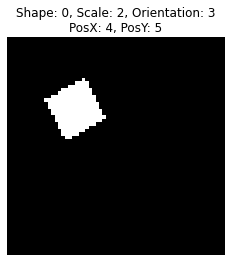

In [17]:
def get_specific_data(args=dict(), cuda=False):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''
    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    """
    helper to plot dSprites images
    """
    x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written 
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2], fontsize=12)
        
def compare_reconstruction(original, recon):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array for recon image
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(recon.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstruction')
    
def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')


names_dict = {'shape': 0, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
        
see_specific_image(names_dict)

# compare_to_density(torch.from_numpy(originals[0]),recons[0])

In [18]:
class DeepConditional(nn.Module):
    def predict(self, x: torch.Tensor) -> TorchDistribution:
        raise NotImplementedError


class _DeepIndepNormal(DeepConditional):
    def __init__(self, backbone: nn.Module, mean_head: nn.Module, logvar_head: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.mean_head = mean_head
        self.logvar_head = logvar_head

    def forward(self, x):
        h = self.backbone(x)
        mean = self.mean_head(h)
        logvar = self.logvar_head(h)
        return mean, logvar

    def predict(self, x) -> Independent:
        mean, logvar = self(x)
        std = (.5 * logvar).exp()
        event_ndim = len(mean.shape[1:])  # keep only batch dimension
        return mean, std, Normal(mean, std).to_event(event_ndim)


class DeepIndepNormal(_DeepIndepNormal):
    def __init__(self, backbone: nn.Module, hidden_dim: int, out_dim: int):
        super().__init__(
            backbone=backbone,
            mean_head=nn.Linear(hidden_dim, out_dim),
            logvar_head=nn.Linear(hidden_dim, out_dim)
        )

In [25]:
class SCM():
  def __init__(self, vae, mu, sigma):
    self.vae = vae
    self.image_dim = vae.image_dim
    self.z_dim = vae.z_dim

    self.mu = mu
    self.sigma = sigma

    self.label_dims = vae.label_shape

    self.init_noise = {
      'N_X'   : dist.Normal(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)),
      'N_Z'   : dist.Normal(torch.zeros(vae.z_dim), torch.ones(vae.z_dim)),
      'N_Y_1' : dist.Uniform(torch.zeros(self.label_dims[1]),torch.ones(self.label_dims[1])),
      'N_Y_2' : dist.Uniform(torch.zeros(self.label_dims[2]),torch.ones(self.label_dims[2])),
      'N_Y_3' : dist.Uniform(torch.zeros(self.label_dims[3]),torch.ones(self.label_dims[3])),
      'N_Y_4' : dist.Uniform(torch.zeros(self.label_dims[4]),torch.ones(self.label_dims[4])),
      'N_Y_5' : dist.Uniform(torch.zeros(self.label_dims[5]),torch.ones(self.label_dims[5]))            
    }

    # self.init_noise = {
    #   'N_X'   : dist.Normal(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)),
    #   'N_Z'   : dist.Normal(torch.zeros(vae.z_dim), torch.ones(vae.z_dim)),
    #   'N_Y_1' : dist.Normal(torch.zeros(self.label_dims[1]),torch.ones(self.label_dims[1])),
    #   'N_Y_2' : dist.Normal(torch.zeros(self.label_dims[2]),torch.ones(self.label_dims[2])),
    #   'N_Y_3' : dist.Normal(torch.zeros(self.label_dims[3]),torch.ones(self.label_dims[3])),
    #   'N_Y_4' : dist.Normal(torch.zeros(self.label_dims[4]),torch.ones(self.label_dims[4])),
    #   'N_Y_5' : dist.Normal(torch.zeros(self.label_dims[5]),torch.ones(self.label_dims[5]))            
    # }

  def f_X(self, Y, Z, N):
    zs = Z.cuda()

    ys = [torch.tensor([0])]
    ys.append(torch.nn.functional.one_hot(torch.round(Y[0]).to(torch.long), int(self.label_dims[1])))
    ys.append(torch.nn.functional.one_hot(torch.round(Y[1]).to(torch.long), int(self.label_dims[2])))
    ys.append(torch.nn.functional.one_hot(torch.round(Y[2]).to(torch.long), int(self.label_dims[3])))
    ys.append(torch.nn.functional.one_hot(torch.round(Y[3]).to(torch.long), int(self.label_dims[4])))
    ys.append(torch.nn.functional.one_hot(torch.round(Y[4]).to(torch.long), int(self.label_dims[5])))
    ys = torch.cat(ys).to(torch.float32).reshape(1, -1).cuda()

    x = self.vae.decoder(zs, ys)

    # print((N < x.cpu()).type(torch.float))

    return (N < x.cpu()).type(torch.float)

  def f_Y(self, N):
    # latent_layers = torch.nn.Sequential(torch.nn.Linear(N.size(0), N.size(0)), 
    #                                     torch.nn.ReLU())
    # # pyro.module("latent_layers", latent_layers)
    # latent_encoder = DeepIndepNormal(latent_layers, N.size(0), N.size(0))
    # pyro.module("latent_encoder", latent_encoder)
    # # to_pyro_module_(latent_encoder)
    # mu, sigma, distribution = latent_encoder.predict(N)
    # return mu, sigma, distribution
    beta = 12
    indices = torch.tensor(np.arange(N.size(0))).to(torch.float32)
    smax = nn.functional.softmax(beta * N)
    argmax_ind = torch.sum(smax * indices)
    # print("argmax_ind: ", argmax_ind)
    return argmax_ind
    # print(N.size(0))
    # spline_transform = T.Spline(N.size(0), count_bins=16)
    # pyro.module("spline_transform ", spline_transform)
    # base_dist = dist.Normal(torch.zeros(N.size(0)), torch.ones(N.size(0)))
    # flow_dist = dist.TransformedDistribution(base_dist, [spline_transform]).to_event(1)
    # sample = flow_dist.sample()
    # # print('sample from f_Y:', sample)
    # return (sample/N.size(0))







  def f_Z(self, N):
    return N * self.sigma + self.mu


  def model(self, noise):
    # pyro.module("latent_encoder", latent_encoder)

    # N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1))

    N_Y_1 = pyro.sample( 'N_Y_1', noise['N_Y_1'].to_event(1) )
    # print("N_Y_1: ", N_Y_1)
    Y_1 = pyro.sample('Y_1', dist.Normal( self.f_Y(N_Y_1), 1e-2))
    # print("Y_1: ",Y_1)

    N_Y_2 = pyro.sample( 'N_Y_2', noise['N_Y_2'].to_event(1) )
    Y_2 = pyro.sample('Y_2', dist.Normal( self.f_Y(N_Y_2), 1e-2) )

    N_Y_3 = pyro.sample( 'N_Y_3', noise['N_Y_3'].to_event(1) )
    Y_3 = pyro.sample('Y_3', dist.Normal( self.f_Y(N_Y_3), 1e-2) )

    N_Y_4 = pyro.sample( 'N_Y_4', noise['N_Y_4'].to_event(1) )
    Y_4 = pyro.sample('Y_4', dist.Normal( self.f_Y(N_Y_4), 1e-2))

    N_Y_5 = pyro.sample( 'N_Y_5', noise['N_Y_5'].to_event(1) )
    Y_5 = pyro.sample('Y_5', dist.Normal( self.f_Y(N_Y_5), 1e-2) )

    # _, _, dist_1 = self.f_Y(N_Y_1)
    # # print(dist_1)
    # Y_1 = pyro.sample('Y_1', dist_1.to_event(1))
    # print("Y_1 sample :", Y_1)
    # _, _, dist_2 = self.f_Y(N_Y_2)
    # Y_2 = pyro.sample('Y_2', dist_2.to_event(1))
    # _, _, dist_3 = self.f_Y(N_Y_3)
    # Y_3 = pyro.sample('Y_3', dist_3.to_event(1))
    # _, _, dist_4 = self.f_Y(N_Y_4)
    # Y_4 = pyro.sample('Y_4', dist_4.to_event(1))
    # _, _, dist_5 = self.f_Y(N_Y_5)
    # Y_5 = pyro.sample('Y_5', dist_5.to_event(1))

    # Y_1 = pyro.sample('Y_1', dist.Normal( self.f_Y(N_Y_1), 1e-2) )
    # Y_2 = pyro.sample('Y_2', dist.Normal( self.f_Y(N_Y_2), 1e-2) )
    # Y_3 = pyro.sample('Y_3', dist.Normal( self.f_Y(N_Y_3), 1e-2) )
    # Y_4 = pyro.sample('Y_4', dist.Normal( self.f_Y(N_Y_4), 1e-2) )
    # Y_5 = pyro.sample('Y_5', dist.Normal( self.f_Y(N
    # 
    # _Y_5), 1e-2) )

    N_Z = pyro.sample( 'N_Z', noise['N_Z'].to_event(1))
    Z = pyro.sample('Z', dist.Normal( self.f_Z(N_Z), 1e-1).to_event(1) )

    # Y_1 = pyro.sample('Y_1', dist.Normal( self.f_Y(N_Y_1), 1e-2) )
    # Y_2 = pyro.sample('Y_2', dist.Normal( self.f_Y(N_Y_2), 1e-1) )
    # Y_3 = pyro.sample('Y_3', dist.Normal( self.f_Y(N_Y_3), 1e-1) )
    # Y_4 = pyro.sample('Y_4', dist.Normal( self.f_Y(N_Y_4), 1e-1) )
    # Y_5 = pyro.sample('Y_5', dist.Normal( self.f_Y(N_Y_5), 1e-1) )

    N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1))
    X = pyro.sample('X', dist.Normal( self.f_X( (Y_1, Y_2, Y_3,Y_4,Y_5), Z, N_X ), 1e-2).to_event(1))

    # return noise and variables
    noise_samples = N_X, (N_Y_1, N_Y_2, N_Y_3, N_Y_4, N_Y_5), N_Z
    variable_samples = X, (Y_1, Y_2, Y_3, Y_4, Y_5), Z
    return variable_samples, noise_samples

  def guide(self, noise):
    mu = {
        'N_X': pyro.param('N_X_mu', 0.5*torch.ones(self.image_dim),constraint = constraints.interval(0., 1.)),
        'N_Z': pyro.param('N_Z_mu', torch.zeros(self.z_dim),constraint = constraints.interval(-3., 3.)),
        'N_Y_1': pyro.param('N_Y_1_mu', 0.5*torch.ones(self.label_dims[1]),constraint = constraints.interval(0., 1.)),
        'N_Y_2': pyro.param('N_Y_2_mu', 0.5*torch.ones(self.label_dims[2]),constraint = constraints.interval(0., 1.)),
        'N_Y_3': pyro.param('N_Y_3_mu', 0.5*torch.ones(self.label_dims[3]),constraint = constraints.interval(0., 1.)),
        'N_Y_4': pyro.param('N_Y_4_mu', 0.5*torch.ones(self.label_dims[4]),constraint = constraints.interval(0., 1.)),
        'N_Y_5': pyro.param('N_Y_5_mu', 0.5*torch.ones(self.label_dims[5]),constraint = constraints.interval(0., 1.))
      }

    sigma = {
          'N_X': pyro.param('N_X_sigma', 0.1*torch.ones(self.image_dim), constraint = constraints.interval(0.0001, 0.5)),
          'N_Z': pyro.param('N_Z_sigma', torch.ones(self.z_dim), constraint = constraints.interval(0.0001, 3.)),
          'N_Y_1': pyro.param('N_Y_1_sigma', 0.1*torch.ones(self.label_dims[1]), constraint = constraints.interval(0.0001, 0.5)),
          'N_Y_2': pyro.param('N_Y_2_sigma', 0.1*torch.ones(self.label_dims[2]), constraint = constraints.interval(0.0001, 0.5)),
          'N_Y_3': pyro.param('N_Y_3_sigma', 0.1*torch.ones(self.label_dims[3]), constraint = constraints.interval(0.0001, 0.5)),
          'N_Y_4': pyro.param('N_Y_4_sigma', 0.1*torch.ones(self.label_dims[4]), constraint = constraints.interval(0.0001, 0.5)),
          'N_Y_5': pyro.param('N_Y_5_sigma', 0.1*torch.ones(self.label_dims[5]), constraint = constraints.interval(0.0001, 0.5))
          }

    for noise_term in noise.keys():
        # print(noise_term)
        pyro.sample(noise_term, dist.Normal(mu[noise_term], sigma[noise_term]).to_event(1))

    
  def update_noise_svi(self, obs_data, intervened_model=None):
        # Condition the model
      if intervened_model is not None:
        obs_model = pyro.condition(intervened_model, obs_data)
      else:
        obs_model = pyro.condition(self.model, obs_data)
        
      pyro.clear_param_store()

      svi = SVI(
          model = obs_model,
          guide = self.guide,
          optim = SGD({"lr": 1e-5, "momentum": 0.1}),
          loss = Trace_ELBO(retain_graph=True)
      )

      num_steps = 1500
      samples = defaultdict(list)
      for t in range(num_steps):
          loss = svi.step(self.init_noise)
          if t % 100 == 0:
              print("step %d: loss of %.2f" % (t, loss))
          for noise in self.init_noise.keys():
              mu = '{}_mu'.format(noise)
              sigma = '{}_sigma'.format(noise)
              samples[mu].append(pyro.param(mu).detach().numpy())
              samples[sigma].append(pyro.param(sigma).detach().numpy())
      means = {k: torch.tensor(np.array(v).mean(axis=0)) for k, v in samples.items()}
      
      # update the inferred noise
      updated_noise = {
          'N_X'  : dist.Normal(means['N_X_mu'], means['N_X_sigma']),
          'N_Z'  : dist.Normal(means['N_Z_mu'], means['N_Z_sigma']),
          'N_Y_1': dist.Normal(means['N_Y_1_mu'], means['N_Y_1_sigma']),
          'N_Y_2': dist.Normal(means['N_Y_2_mu'], means['N_Y_2_sigma']),
          'N_Y_3': dist.Normal(means['N_Y_3_mu'], means['N_Y_3_sigma']),
          'N_Y_4': dist.Normal(means['N_Y_4_mu'], means['N_Y_4_sigma']),
          'N_Y_5': dist.Normal(means['N_Y_5_mu'], means['N_Y_5_sigma']),
      }
      return updated_noise


In [26]:
# import pyro.poutine as poutine
# trace = poutine.trace(model1).get_trace()

Y:  tensor([[ 0.,  1.,  2., 36., 13., 24.]], device='cuda:0')


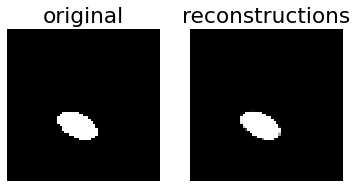

In [27]:
original, y_original = get_specific_data(cuda=True)
print('Y: ', y_original)
mu, sigma = vae.encoder(original, vae.remap_y(y_original))
B = 100
zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
ys = torch.cat([vae.remap_y(y_original) for a in range(B)], 0)
rs = vae.decoder(zs.cuda(), ys).detach()
compare_to_density(original, rs)

# y_new = torch.tensor(y_original)
# y_new[0,1] = (y_original[0,1] + 3) % 2
# print('bottom: ', y_new)
# zs = torch.cat([dist.Normal(mu.cpu(), sigma.cpu()).sample() for a in range(B)], 0)
# ys = torch.cat([vae.remap_y(y_new) for a in range(B)], 0)
# rs = vae.decoder.forward(zs.cuda(), ys).detach()
# compare_to_density(original, rs)

In [28]:
# ox, y = get_specific_data(cuda=True)
# cond_data = {}
# for i in range(1, 6):
#     cond_data["Y_{}".format(i)] = torch.tensor(y[0, i].cpu()).to(torch.float32)
# print(cond_data)

In [29]:
# scm = SCM(vae, mu.cpu(), sigma.cpu())

In [32]:
# cond_data['Y_1'] = torch.tensor(1.)
# cond_data['Y_2'] = torch.tensor(4.)
# conditioned_model = pyro.condition(SCM.model, data=cond_data)#
# mu.cpu(), sigma.cpu()
scm = SCM(vae, mu.cpu(), sigma.cpu())
ox, y = get_specific_data(cuda=True)
# print(ox)
cond_data = {}
for i in range(1, 6):
    cond_data["Y_{}".format(i)] = torch.tensor(y[0, i].cpu()).to(torch.float32)
print("Cond data: ", cond_data)

cond_noise = scm.update_noise_svi(cond_data)
# print("cond_noise: ", cond_noise)

Cond data:  {'Y_1': tensor(0.), 'Y_2': tensor(4.), 'Y_3': tensor(13.), 'Y_4': tensor(17.), 'Y_5': tensor(16.)}
step 0: loss of 157648.54
step 100: loss of inf
step 200: loss of inf
step 300: loss of inf
step 400: loss of inf
step 500: loss of inf
step 600: loss of inf
step 700: loss of -4000.11
step 800: loss of inf
step 900: loss of -4254.06
step 1000: loss of inf
step 1100: loss of -4976.17
step 1200: loss of inf
step 1300: loss of inf
step 1400: loss of inf


In [146]:
# import pyro.poutine as poutine
# trace = poutine.trace(scm).get_trace()

In [147]:
print(cond_noise['N_Y_1'].mean)

tensor([0.2875, 0.3506, 0.7964])


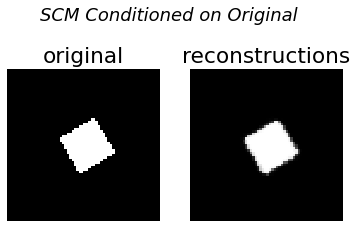

In [33]:
rxs = []
for i in range(1000):
    (rx, ry, rz), noise = scm.model(cond_noise)
    rxs.append(rx)
# print(torch.cat(rxs).reshape(640, 640).shape)
compare_to_density(ox, torch.cat(rxs))
_ = plt.suptitle("SCM Conditioned on Original", fontsize=18, fontstyle='italic')
# z = torch.cat(rxs).reshape(640, 640).cpu().detach().numpy()
# plt.imshow(z, cmap='gray',  interpolation='nearest')

In [58]:
cond_noise

{'N_X': Normal(loc: torch.Size([4096]), scale: torch.Size([4096])),
 'N_Z': Normal(loc: torch.Size([50]), scale: torch.Size([50])),
 'N_Y_1': Normal(loc: torch.Size([3]), scale: torch.Size([3])),
 'N_Y_2': Normal(loc: torch.Size([6]), scale: torch.Size([6])),
 'N_Y_3': Normal(loc: torch.Size([40]), scale: torch.Size([40])),
 'N_Y_4': Normal(loc: torch.Size([32]), scale: torch.Size([32])),
 'N_Y_5': Normal(loc: torch.Size([32]), scale: torch.Size([32]))}

In [73]:

# intervening on Shape, posX and PosY 
intervened_model = pyro.do(scm.model, data={
    "Y_1": torch.tensor(0.),
    # "Y_2": torch.tensor(0.),
    # "Y_3": torch.tensor(5.),
    # "Y_4": torch.tensor(5.),
    # "Y_5": torch.tensor(25.),
})

noise_data = {}
for term, d in cond_noise.items():
    # print(d.loc)
    noise_data[term] = d.loc

# print(noise_data)
intervened_noise = scm.update_noise_svi(noise_data, intervened_model)

N_Y_1:  tensor([0.2801, 0.3601, 0.7963])
argmax_ind:  tensor(1.9907)
Y_1:  tensor(0.)
argmax_ind:  tensor(0.9893)
argmax_ind:  tensor(29.1481)
argmax_ind:  tensor(23.1201)
argmax_ind:  tensor(0.5828)
step 0: loss of -5118.27
N_Y_1:  tensor([0.2801, 0.3601, 0.7963])
argmax_ind:  tensor(1.9907)
Y_1:  tensor(0.)
argmax_ind:  tensor(0.9893)
argmax_ind:  tensor(29.1481)
argmax_ind:  tensor(23.1201)
argmax_ind:  tensor(0.5828)
N_Y_1:  tensor([0.2801, 0.3601, 0.7963])
argmax_ind:  tensor(1.9907)
Y_1:  tensor(0.)
argmax_ind:  tensor(0.9893)
argmax_ind:  tensor(29.1481)
argmax_ind:  tensor(23.1201)
argmax_ind:  tensor(0.5828)
N_Y_1:  tensor([0.2801, 0.3601, 0.7963])
argmax_ind:  tensor(1.9907)
Y_1:  tensor(0.)
argmax_ind:  tensor(0.9893)
argmax_ind:  tensor(29.1481)
argmax_ind:  tensor(23.1201)
argmax_ind:  tensor(0.5828)
N_Y_1:  tensor([0.2801, 0.3601, 0.7963])
argmax_ind:  tensor(1.9907)
Y_1:  tensor(0.)
argmax_ind:  tensor(0.9893)
argmax_ind:  tensor(29.1481)
argmax_ind:  tensor(23.1201)
arg

N_Y_1:  tensor([0.8763, 0.4210, 0.5558])
argmax_ind:  tensor(0.0458)
Y_1:  tensor(0.)
argmax_ind:  tensor(1.0050)
argmax_ind:  tensor(13.9401)
argmax_ind:  tensor(19.7439)
argmax_ind:  tensor(9.7202)
(tensor(0.), tensor(1.0118), tensor(13.9386), tensor(19.7340), tensor(9.7070))


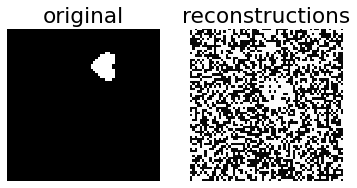

In [74]:
(rx1, ry, _), _ = intervened_model(scm.init_noise)
compare_to_density(ox, rx1)
print(ry)

N_Y_1:  tensor([0.2675, 0.3139, 0.8504])
argmax_ind:  tensor(1.9966)
Y_1:  tensor(0.)
argmax_ind:  tensor(0.9144)
argmax_ind:  tensor(29.1200)
argmax_ind:  tensor(23.1625)
argmax_ind:  tensor(0.7855)
N_Y_1:  tensor([0.2540, 0.3495, 0.7416])
argmax_ind:  tensor(1.9854)
Y_1:  tensor(0.)
argmax_ind:  tensor(0.9916)
argmax_ind:  tensor(29.6484)
argmax_ind:  tensor(22.9335)
argmax_ind:  tensor(1.2484)
N_Y_1:  tensor([0.1798, 0.5022, 0.8670])
argmax_ind:  tensor(1.9871)
Y_1:  tensor(0.)
argmax_ind:  tensor(1.0600)
argmax_ind:  tensor(29.0050)
argmax_ind:  tensor(22.9886)
argmax_ind:  tensor(0.9835)
N_Y_1:  tensor([0.3404, 0.2375, 0.8065])
argmax_ind:  tensor(1.9915)
Y_1:  tensor(0.)
argmax_ind:  tensor(0.9873)
argmax_ind:  tensor(28.9987)
argmax_ind:  tensor(23.0007)
argmax_ind:  tensor(1.0541)
N_Y_1:  tensor([0.2778, 0.3427, 0.8636])
argmax_ind:  tensor(1.9963)
Y_1:  tensor(0.)
argmax_ind:  tensor(1.0069)
argmax_ind:  tensor(28.9162)
argmax_ind:  tensor(22.9136)
argmax_ind:  tensor(0.9185)


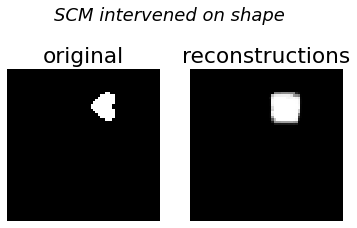

In [75]:
rxs = []
for i in range(1000):
     (cfo1, ny1, nz1), _= intervened_model(cond_noise)
     # print(cfo1.shape)
     # print(nz1)
     rxs.append(cfo1)
# print(torch.cat(rxs).shape)
compare_to_density(ox, torch.cat(rxs))
_ = plt.suptitle("SCM intervened on shape", fontsize=18, fontstyle='italic')